# Seminar "Computational Social Science" - Data Analysis

In [27]:
# import
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from scipy import stats
import re
import os

# set working directory
wd = 'D:/IMDb Daten/'
os.chdir(wd)

### Functions

In [28]:
# import data from tsv format (separated by \t) as pandas dataframe
def import_tsv(data_path):
    data_df = pd.read_csv(data_path, sep='\t')
    return data_df

# save data as csv (but with \t separator) to working directory (default) or path as given
def save_csv(df, filename, path):
    df.to_csv(path+filename+'.csv', sep='\t', index=False)

### Import data and prepare

In [29]:
df_writers_producers = import_tsv(wd+'/df_writers_producers6.csv')

# sets of all writers and producers
writers = set(df_writers_producers.writer.tolist())
producers = set(df_writers_producers.producer.tolist())

# number of writers/producers
print(len(writers))     # 4,667
print(len(producers))   # 2,448

4667
2448


In [30]:
# drop cases where gender is 'other'
df_writers_producers['deleteOther'] = 0
for i in df_writers_producers.index:
    if df_writers_producers.loc[i,'gender_writer'] == 'other':
        df_writers_producers.loc[i,'deleteOther'] = 1
    if df_writers_producers.loc[i,'gender_producer'] == 'other':
        df_writers_producers.loc[i,'deleteOther'] = 1

df_writers_producers=df_writers_producers[df_writers_producers.deleteOther == 0]        


In [31]:
print(len(df_writers_producers.index)) 
# number of collaborations: 13,304

13304


In [32]:
# sets of all writers and producers
writers = set(df_writers_producers.writer.tolist())
producers = set(df_writers_producers.producer.tolist())

# number of writers/producers
print(len(writers))     # 4,660
print(len(producers))   # 2,446

4660
2446


### Create graph

In [7]:
# empty graph
G=nx.Graph()

In [8]:
# add nodes
# mark different sets of nodes by setting attribute bipartite to 1 for writers,
# and 0 for producers

G.add_nodes_from(writers, bipartite=1)
G.add_nodes_from(producers, bipartite=0)

In [9]:
#  produce nested list: for each collaboration one list (writer, producer, weight)
pairs = []
for i in df_writers_producers.index:
    temp_w=df_writers_producers.loc[i, 'writer']
    temp_p= df_writers_producers.loc[i, 'producer']
    temp_c = df_writers_producers.loc[i, 'coop']
    pair=[temp_w, temp_p, temp_c]
    pairs.append(pair)

In [10]:
# add weighted edges from list
G.add_weighted_edges_from(pairs)

In [11]:
# add gender and name information to nodes

# 1) load data with gender info
df_name_info = import_tsv('df_name_info7.csv')

# 2) make dicts with unique person identifier (nconst) as key and gender/name as values out of df
dict_gender = pd.Series(df_name_info.gender.values,index=df_name_info.nconst).to_dict()
dict_name = pd.Series(df_name_info.primaryName.values,index=df_name_info.nconst).to_dict()

# 3) set attributes gender and name for each node
nx.set_node_attributes(G, dict_gender, 'gender')
nx.set_node_attributes(G, dict_name, 'name')

In [12]:
# make containers / set top nodes and bottom nodes for further processing

# 1) top nodes are producers
top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}

# 2) bottom nodes are writers
bottom_nodes = set(G) - top_nodes

### Check graph properties

In [13]:
print(bipartite.is_bipartite(G))       # graph is bipartite
print(nx.is_weighted(G))               # graph is weighted
print(nx.is_connected(G))              # graph is not connected

True
True
False


### Analyse components

In [14]:
Gcc = sorted(nx.connected_components(G), 
             key=len, reverse=True)
print(len(Gcc))                              # 441 components
print(len(Gcc[0])/len(G))                    # largest component makes up around 75 percent of nodes 

# subgraph from giant component
G0 = G.subgraph(Gcc[0])

# all individuals from giant component
gc_all = list(Gcc[0])

# lists of writers / producers in giant component
gc_writers = []
gc_producers = []
for name in gc_all:
    if name in writers:
        gc_writers.append(name)
        continue
    if name in producers:
        gc_producers.append(name)

441
0.7521812552772306


### Degree Distribution
#### 1) Unweighted

In [15]:
deg_prod, deg_writer = bipartite.degrees(G, bottom_nodes, weight=None)

deg_prod = dict(deg_prod)
deg_writer = dict(deg_writer)

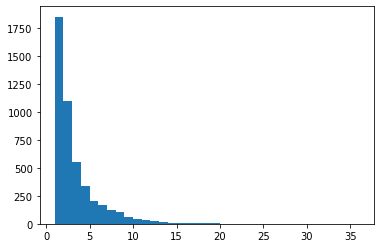

In [18]:
# degree distribution writer
a=list(deg_writer.values())
a = [int(x) for x in a]
plt.hist(a, bins=range(min(a),max(a)))
plt.show()

#### 2) Weighted

In [25]:
deg_prod_w, deg_writer_w = bipartite.degrees(G, bottom_nodes, weight='weight')

deg_prod_w = dict(deg_prod_w)
deg_writer_w = dict(deg_writer_w)

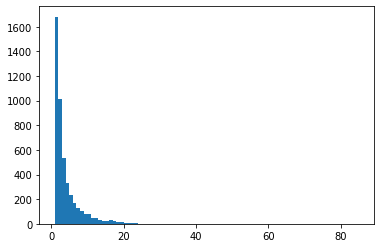

In [26]:
# degree distribution writers (weighted)
a=list(deg_writer_w.values())
a = [int(x) for x in a]
plt.hist(a, bins=range(min(a),max(a)))
plt.show()

### Visualization

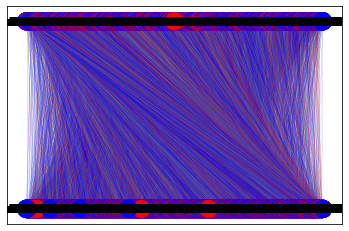

In [15]:
# get positions
pos = nx.drawing.layout.bipartite_layout(G, top_nodes, align='horizontal', scale=1, 
                                         center=None, aspect_ratio=1.3333333333333333)

# create empty list for node colors
node_color = []

# for each node in the graph
for node in G.nodes(data=True):
    if 'female' in node[1]['gender']:
        node_color.append('red')
    elif 'male' in node[1]['gender']:
        node_color.append('blue')

# add color attribute to edges
for (u, v) in G.edges():
    if dict_gender[u] == 'male' and  dict_gender[v] == 'male':
        G.add_edge(u,v, color="blue")
        continue
    if dict_gender[u] == 'female' and  dict_gender[v] == 'female':
        G.add_edge(u,v, color="red")
        continue
    else:
        G.add_edge(u,v, color='grey')

# list edge_color for edges
edge_color = []
for (u, v, w) in G.edges(data=True):
    color=w['color']
    edge_color.append(color)

# draw graph
nx.draw_networkx(G, pos=pos, node_size=300, width=0.1, node_color=node_color, edge_color=edge_color)
plt.show()

### Description

In [30]:
# number of writers and producers

print(1, len(writers))
print(2, len(producers))

1 4660
2 2446


In [36]:
# female writers
writers_f=[]
for name in writers:
    if dict_gender[name] == "female":
        writers_f.append(name)
print(1, len(writers_f))

# male writers
writers_m=[]
for name in writers:
    if dict_gender[name] == "male":
        writers_m.append(name)
print(2, len(writers_m))

# female producers
producers_f=[]
for name in producers:
    if dict_gender[name] == "female":
        producers_f.append(name)
print(3, len(producers_f))


# male producers
producers_m=[]
for name in producers:
    if dict_gender[name] == "male":
        producers_m.append(name)
print(4, len(producers_m))

1 1580
2 3080
3 887
4 1559


### Analysis of Centrality

In [16]:
# compute centrality measures (from giant component) --> takes some minutes
cc = bipartite.closeness_centrality(G0, gc_writers)
bc = bipartite.betweenness_centrality(G0, gc_writers)
dc = bipartite.degree_centrality(G0, gc_writers)

In [17]:
# drop producers from centrality dicts
for i in range(len(gc_producers)):
    key = gc_producers[i]
    del cc[key]
    del bc[key]
    del dc[key]

# put centrality measure values in new dataframe
df_centralities = pd.DataFrame({'cc':pd.Series(cc),'bc':pd.Series(bc),'dc':pd.Series(dc)})
df_centralities.reset_index(level=0, inplace=True)
df_centralities.columns = ['nconst', 'closeness', 'betweenness', 'degree']

# add name and gender info
df_centralities = pd.merge(df_centralities, df_name_info[['nconst','primaryName','gender']], how='left', on='nconst')

In [18]:
# save
save_csv(df_centralities, 'df_centralities1', path=wd)  

In [19]:
# describe

print(df_centralities.groupby("gender")['closeness'].describe())
# female mean: 0.263316
# male mean: 0.267163

print(df_centralities.groupby("gender")['betweenness'].describe())
# female mean: 0.000666
# male mean: 0.000694

print(df_centralities.groupby("gender")['degree'].describe())
# female mean: 0.001875
# male mean: 0.002013

         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female  1275.0  0.263316  0.043701  0.126744  0.237394  0.267217  0.296269   
male    2473.0  0.267163  0.040884  0.126744  0.241211  0.270461  0.297393   

             max  
gender            
female  0.357927  
male    0.365909  
         count      mean       std  min  25%       50%       75%       max
gender                                                                    
female  1275.0  0.000666  0.001526  0.0  0.0  0.000035  0.000567  0.016236
male    2473.0  0.000694  0.001673  0.0  0.0  0.000053  0.000620  0.032628
         count      mean       std       min       25%       50%       75%  \
gender                                                                       
female  1275.0  0.001875  0.001665  0.000626  0.000626  0.001252  0.002505   
male    2473.0  0.002013  0.001841  0.000626  0.000626  0.001252  0.002505   

In [20]:
# Levene-test: test for homogeneity of variances
# H0 is that there is homogeneity of variances
# p < 0.05: reject H0 --> assume no homogeneity of variances

# new separate datasets for males and females
male = df_centralities[(df_centralities['gender'] == 'male')]
male.reset_index(inplace= True)
female = df_centralities[(df_centralities['gender'] == 'female')]
female.reset_index(inplace= True)

# closeness: test significaant --> no homogeneity of variances
print('closeness: ', stats.levene(male['closeness'], female['closeness']))

# betweenness: test insignificant --> homogeneity of variances
print('betweenness: ', stats.levene(male['betweenness'], female['betweenness']))

# degree: test significaant --> no homogeneity of variances
print('degree: ',stats.levene(male['degree'], female['degree']))

closeness:  LeveneResult(statistic=6.21080255666399, pvalue=0.01274020832129527)
betweenness:  LeveneResult(statistic=0.23305597257811328, pvalue=0.6292952808716595)
degree:  LeveneResult(statistic=5.7731179613672134, pvalue=0.01632148901170619)


In [21]:
# check for normal distribution
# H0 is that the data is normally distributed
# p < 0.05: reject H0 --> assume that data not drawn from normal distribution

print('closeness 1:',stats.shapiro(female['closeness']))          
print('closeness 2:',stats.shapiro(male['closeness']))            

print('betweenness 1:',stats.shapiro(female['betweenness']))           
print('betweenness 2:',stats.shapiro(male['betweenness']))          

print('degree 1:',stats.shapiro(female['degree']))             
print('degree 2:',stats.shapiro(male['degree']))               

# reject H0 for all samples

closeness 1: (0.9794097542762756, 1.6419001575007641e-12)
closeness 2: (0.9860884547233582, 7.965314029829886e-15)
betweenness 1: (0.4877440333366394, 0.0)
betweenness 2: (0.4387094974517822, 0.0)
degree 1: (0.7407894134521484, 1.1775391255414303e-40)
degree 2: (0.7384718656539917, 0.0)


In [22]:
# normality criterion violated --> non-parametric tests --> e.g. Mann-Whitney-U-Test

print('closeness:',stats.mannwhitneyu(female['closeness'], male['closeness']))        # pvalue=0.017851542287967474
print('betweenness:',stats.mannwhitneyu(female['betweenness'], male['betweenness']))  # pvalue=0.15357243834218948
print('degree:',stats.mannwhitneyu(female['degree'], male['degree']))                 # pvalue=0.02874741847105109

closeness: MannwhitneyuResult(statistic=1510617.5, pvalue=0.017851542287967474)
betweenness: MannwhitneyuResult(statistic=1545145.0, pvalue=0.15357243834218948)
degree: MannwhitneyuResult(statistic=1518621.0, pvalue=0.02874741847105109)


### Analysis of Tie Strength

1) Consider all nodes

In [23]:
# new dataframe with the average number of cooperations per tie per node (=average tie weight per node)
df_coop = df_writers_producers.groupby('writer')['coop'].mean().to_frame(name='avg_coop').reset_index()
df_coop = pd.merge(df_coop, df_name_info[['nconst','gender']], how='left', left_on='writer', right_on='nconst')

In [25]:
# describe
df_coop.groupby("gender")['avg_coop'].describe()
# mean female: 1.16
# mean male: 1.22

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,1580.0,1.159877,0.413461,1.0,1.0,1.0,1.00,7.0
male,3080.0,1.217528,0.445612,1.0,1.0,1.0,1.25,4.5


In [26]:
# new separate dataframes for male/female
male = df_coop[(df_coop['gender'] == 'male')]
male.reset_index(inplace= True)

female = df_coop[(df_coop['gender'] == 'female')]
female.reset_index(inplace= True)

In [27]:
# Levene test for homogeneity of variances
stats.levene(male['avg_coop'], female['avg_coop'])

# test is significant --> no homogeneity of variances

LeveneResult(statistic=18.34411016301136, pvalue=1.8810201886300806e-05)

In [29]:
# Shapiro test for normal distribution

print(1,stats.shapiro(female['avg_coop']))      
print(2,stats.shapiro(male['avg_coop']))        

# both significant --> no normal distribution

1 (0.4374329447746277, 0.0)
2 (0.5632578730583191, 0.0)


In [30]:
# Mann Whitney U test
stats.mannwhitneyu(female['avg_coop'], male['avg_coop'])    #pvalue=1.1646186928286652e-07

MannwhitneyuResult(statistic=2254026.0, pvalue=1.1646186928286652e-07)

2) Without nodes that have only one tie that has weight 1

In [31]:
# find writers who only have one collaboration entry
one_occ = []
numOfOccWriter = df_writers_producers.writer.value_counts().to_frame(name='num').reset_index()
numOfOccWriter = numOfOccWriter.rename(columns={"index": "nconst"})

for i in numOfOccWriter.index:
    if numOfOccWriter.loc[i,'num'] == 1:
        one_occ.append(numOfOccWriter.loc[i,'nconst'])
        
# find writers who only have one collaboration entry that is strength 1:
one_occ_strength_1 = []
for i in df_writers_producers.index:
    if df_writers_producers.loc[i,'writer'] in one_occ:
        if df_writers_producers.loc[i,'coop'] == 1:
            one_occ_strength_1.append(df_writers_producers.loc[i,'writer'])

In [32]:
# new dataframe with average number of collaborations per tie
df_coop2 = df_coop[~df_coop['writer'].isin(one_occ_strength_1)]
df_coop2.groupby('gender')['avg_coop'].describe()

# mean female: 1.26
# mean male: 1.34

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,986.0,1.256192,0.499340,1.0,1.0,1.0,1.4,7.0
male,1993.0,1.336169,0.516743,1.0,1.0,1.0,1.5,4.5


In [33]:
# new separate dataframes for male/female
male = df_coop2[(df_coop2['gender'] == 'male')]
male.reset_index(inplace= True)

female = df_coop2[(df_coop2['gender'] == 'female')]
female.reset_index(inplace= True)

In [34]:
# Levene test for homogeneity of variances
stats.levene(male['avg_coop'], female['avg_coop'])

# test is significant --> no homogeneity of variances

LeveneResult(statistic=16.15547830469976, pvalue=5.979615540492086e-05)

In [35]:
# Shapiro test for normal distribution

print(1,stats.shapiro(female['avg_coop']))       
print(2,stats.shapiro(male['avg_coop']))

# tests both significant --> no normal distribution assumed

1 (0.5608026385307312, 3.783505853677006e-44)
2 (0.7001656889915466, 0.0)


In [36]:
# Mann Whitney U test
stats.mannwhitneyu(female['avg_coop'], male['avg_coop'])    #pvalue=2.2354932432277508e-07

MannwhitneyuResult(statistic=880973.0, pvalue=2.2354932432277508e-07)

### Analysis of Gender Homophily

In [18]:
# describe with contingency tables

# producers in columns, writers in rows
# producers as independent variable since they do the hiring
pd.crosstab(df_writers_producers['gender_writer'],df_writers_producers['gender_producer'])

gender_producer,female,male
gender_writer,,
female,1619,2681
male,3064,5940


In [19]:
pd.crosstab(df_writers_producers['gender_writer'],df_writers_producers['gender_producer'],normalize='columns',margins=True)

gender_producer,female,male,All
gender_writer,,,
female,0.345719,0.310985,0.323211
male,0.654281,0.689015,0.676789


In [24]:
# describe gender composition of writers

# writer list
writers = list(writers)

# number of female writers: 1580
n_w_f = 0
for name in writers:
    if dict_gender[name] == "female":
        n_w_f = n_w_f+1
print(1, n_w_f)

# number of male writers: 3080
n_w_m = 0
for name in writers:
    if dict_gender[name] == "male":
        n_w_m = n_w_m+1
print(2, n_w_m)
        
# total number of writers: 4660
n_w = len(writers)
print(3, n_w)

# percentage of female writers: 0.33905579399141633
perc_w_f = n_w_f / n_w
print(4, perc_w_f)

# percentage of male writers: 0.6609442060085837
perc_w_m = n_w_m / n_w
print(5, perc_w_m)

1 1580
2 3080
3 4660
4 0.33905579399141633
5 0.6609442060085837


In [26]:
# average number of collaborations with male / female producers per writer

# 1) dataframe with genders of all writers worked with per producer (separated by comma):
df_hp = df_writers_producers.groupby('producer')['gender_writer'].apply(lambda x: ','.join(x)).to_frame(name='writers').reset_index()

# 2) variables for number of male/female writers worked
df_hp['coops_male'] = 0
df_hp['coops_female'] = 0

for i in df_hp.index:
    text = df_hp.loc[i,'writers']
    alls=len(re.findall(r',', text))+1
    females = len(re.findall(r'female',text))
    males=alls-females
    df_hp.loc[i,'coops_male'] = males
    df_hp.loc[i,'coops_female'] = females

# 3) merge gender of producer
df_hp = pd.merge(df_hp, df_name_info[['nconst','gender']], how='left', left_on='producer', right_on='nconst')

# drop nconst and rename gender
del df_hp['nconst']
df_hp = df_hp.rename(columns={"gender": "gender_producer"})
    
# 4) average number of ties (1) female / (2) male proucers have to female writers: 
ties_f = df_hp.groupby('gender_producer')['coops_female'].mean()
s_f = ties_f['female']
print(1, s_f) # 1.8252536640360766
d_m = ties_f['male']        
print(2, d_m) # 1.7196921103271328

# 5) average number of ties (1) female / (2) male producers have to male writers
ties_m = df_hp.groupby('gender_producer')['coops_male'].mean()
d_f = ties_m['female']      
print(3, d_f) # 3.4543404735062007
s_m = ties_m['male']        
print(4, s_m) # 3.8101347017318794

1 1.8252536640360766
2 1.7196921103271328
3 3.4543404735062007
4 3.8101347017318794


In [29]:
# homophily indices

# 1) homophily index female
H_f = s_f / (s_f + d_f)
print(1, H_f)
# 0.3457185564808883

# 2) homophily index male
H_m = s_m / (s_m + d_m)
print(2, H_m)
# 0.6890151954529637

# 3) adjust for population sizes: inbreeding homophily index
IH_f = (H_f - perc_w_f) / (1-perc_w_f)
print(3,IH_f)      # 0.010080673117188082
IH_m = (H_m - perc_w_m) / (1-perc_w_m)
print(4,IH_m)      # 0.08279165241190564

1 0.3457185564808883
2 0.6890151954529637
3 0.010080673117188082
4 0.08279165241190564
